<p float="left">
    <img src="https://earthdata.nasa.gov/img/earthdata-fb-image.jpg" width="300">
    
</p>

## **2021 ESIP Winter Meeting: Science in the Cloud Demos**

<!-- <img align="left" src="https://earthdata.nasa.gov/img/earthdata-fb-image.jpg" width="250"> -->

### Working with Cloud-Based NASA Earth Observations Data and Tools: 
#### AWS in-region access of NASA Earthdata products

This notebook provides a basic end-to-end workflow to interact with data "in-place" from the NASA Earthdata Cloud, by accessing AWS S3 locations provided by [NASA Harmony](http://harmony.earthdata.nasa.gov/) outputs without the need to download data. While these outputs can be downloaded locally, the cloud offers the ability to scale compute resources to perform analyses over large areas and time spans, which is critical as data volumes continue to grow. 

This workflow combines search, discovery, access, reformatting, basic analyses, and plotting components presented during the AGU 2020 Fall Meeting Workshop "Working with Cloud-Based NASA Earth Observations Data and Tools", with all materials available from https://github.com/podaac/AGU-2020. Though the example we're working with in this notebook only focuses on a small time and area to account for a large number of concurrent processing requests, this workflow can be modified and scaled up to suit a larger time range and region of interest. The Learning Objectives of the original tutorial are copied below:

#### Learning objectives:

- Understand the Pangeo BinderHub environment used during the workshop and how to execute code within a Jupyter Notebook
- Search for Liquid Water Equivalent (LWE) data from GRACE/GRACE-FO and Sea Surface Salinity (SSS) from SMAP 
- Execute programmatic data access queries, plotting, and direct in-region cloud access using open source Python libraries.
- Access data in Zarr format from Earthdata Cloud (AWS)
- Subset both, plot and compare coincident data.
- Identify resources, including the Earthdata Cloud Primer, for getting started with Amazon Web Services outside of the Workshop to access and work with data with a cloud environment.

___

<p float="left">
    <img src="https://github.com/pangeo-data/pangeo/raw/master/docs/_static/pangeo_simple_logo.svg" width="200">
    
</p>


### __Pangeo BinderHub__

First, some basics on the Pangeo compute environment used during the live workshop and how to interact with Jupyter Notebooks and the Jupyter Lab interface.

* [Pangeo BinderHub](https://binder.pangeo.io/): A multi-user server for interactive data analysis. This Hub is running in the AWS `us-west-2` region, which is where all Earthdata Cloud data and transformation service outputs are located. Pangeo is supported, in part, by the National Science Foundation (NSF) and the National Aeronautics and Space Administration (NASA). Google provided compute credits on Google Compute Engine. The Pangeo community promotes open, reproducible, and scalable science. We thank all at Pangeo for supporting the 2020 AGU Workshop.

See instructions at the bottom of this notebook for how to set up your own AWS EC2 instance so that you can perform the same cloud access within your personal AWS environment. 

___
### __Import modules__


In [1]:
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser
from pprint import pprint
import intake
#import rasterio
import zarr
import matplotlib.pyplot as plt
import dask.array as da
import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import s3fs
from pystac import STAC_IO, Catalog
from IPython.display import HTML
import json

%matplotlib inline

## __Earthdata Login__

A NASA Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

At this point in time (as we are still transitioning to a cloud environment), in order to access data from the Earthdata Cloud, you need early access permissions.

In [2]:
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  amy.steiker
Password:  ·········


___
## __Data Search and Discovery__


[**JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height Coastal Resolution Improvement (CRI) Filtered Release 06 Version 02**](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2)

Provides land water equivalent (LWE) thickness for observing seasonal changes in water storage around the river. When discharge is high, the change in water storage will increase, pointing to a wet season. This product provides gridded monthly global water storage/height anomalies in a single data file in netCDF format, and can be used for analysis for ocean, ice, and hydrology phenomena. Source data are from [GRACE](https://podaac.jpl.nasa.gov/GRACE) and [GRACE-FO](https://podaac.jpl.nasa.gov/GRACE-FO)

#### First, define the region of interest over the Amazon river basin and set the temporal range for the year 2019:

In [3]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-52,-2,-43,6'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2020-11-01T00:00:00Z,2020-11-30T23:59:59Z'

#### Set up dictionary with the data product of interest

Before we search programmatically using the [Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), we can use NASA Earthdata Search to visualize file coverage over multiple data sets and to access the same data you will be working with below: 
[Earthdata Search project](https://search.earthdata.nasa.gov/projects?p=!C1938032626-POCLOUD!C1940468263-POCLOUD!C1650311642-PODAAC!C1664148252-PODAAC&pg[1][v]=t&pg[1][gsk]=-start_date&pg[2][v]=t&pg[2][gsk]=-start_date&pg[3][v]=t&pg[4][v]=t&q=TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2&sb[0]=-52%2C-2%2C-43%2C6&m=2.00390625!-47.50048828125!6!1!0!0%2C2&qt=2019-04-01T00%3A00%3A00.000Z%2C2019-04-30T23%3A59%3A59.999Z&tl=1591244551!4!!)

In [4]:
search_parameters = { 
        'short_name': 'TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2',
        'provider': 'POCLOUD',
        'bounding_box': bounding_box,
        'temporal': temporal,
        'token': _token,
}

#### Discover file number and file size 

Using CMR search, determine the number of files that exist over this time and area of interest, as well as the average size and total volume of those files.

In [5]:
search_url = "https://cmr.earthdata.nasa.gov/search/granules"
output_format="json"

parameters = {
        "scroll": "true",
        "page_size": 100,
}

response = requests.post(f"{search_url}.{output_format}", params=parameters, data=search_parameters)
response.raise_for_status()

hits = int(response.headers['CMR-Hits'])
if hits > 0:
    print(f"Found {hits} files")
    results = json.loads(response.content)
    granules = []
    granules.extend(results['feed']['entry'])
    granule_sizes = [float(granule['granule_size']) for granule in granules]
    print(f"The total size of all files is {sum(granule_sizes):.2f} MB")
else:
    print("Found no hits")

Found 1 files
The total size of all files is 755.46 MB


#### Locate the data access URLs provided by the data product (collection) metadata:

GRACE data:

In [6]:
r = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
                 params=search_parameters)
grace_gran = r.json()
print("files returned:",grace_gran['hits'])
grace_gran['items'][0]['umm']['RelatedUrls']

files returned: 1


[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

___
## __Data Access from NASA Earthdata Harmony__

There are several different methodologies to search and access data depending on your use case. The URLs above can be located with the data granule (file) metadata, and pulled into a list that can then be bulk downloaded as you've seen in the previous tutorials.

[Harmony](https://harmony.earthdata.nasa.gov/) is a growing effort across the NASA EOSDIS community to provide a consistent method to access and perform data subsetting and transformation services for data in the Earthdata Cloud. These services are processed in the cloud, with data archived in the cloud, and outputs can be accessed by downloading to a local machine or through direct in-region access via Amazon Web Services. These next steps walk through this access method to access the data outputs directly within the AWS `us-west-2` region so that we can read the data into memory within this AWS hub environment. 


<img align="left" src="Harmony diagram.png" width=600>

#### __Get collection ID for Harmony__

Harmony operates on an input Collection concept-id (a CMR construct). Here's how you identify the CMR concept-id for the data products of interest:

In [7]:
r = requests.get(url="https://cmr.earthdata.nasa.gov/search/collections.umm_json", 
                 params=search_parameters)

grace_coll = r.json()
grace_coll['hits']
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_id = grace_coll_meta['concept-id']
print('GRACE collection id:', grace_coll_id)

GRACE collection id: C1938032626-POCLOUD


#### __Request GRACE data reformatted to Zarr__:

[Zarr](https://zarr.readthedocs.io/en/stable/) is a format for the storage of chunked, compressed, N-dimensional arrays. Zarr also enables you to store arrays in memory, on disk, inside a Zip file, or on S3. Harmony's Zarr Reformatter service will transform the SMAP data from its native NetCDF format to Zarr, to allow us to open and download/read just the data that we require for our Amazon Basin study area.


For our science use case, ideally we'd also want to request an entire year but since this can take a long time to process with many concurrent requests during this live workshop, we will just request a month of data for demonstration purposes.

In [8]:
harmony_root = 'https://harmony.earthdata.nasa.gov'
harmony_params = {
    'collection_id': grace_coll_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':'(-2:6)',
    'lon':'(-52:-43)',
    'start': '2020-11-01T00:00:00Z',
    'stop':'2020-11-30T23:59:59Z',
    'format': 'application/x-zarr',
}

grace_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**harmony_params)
print(grace_url)

https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=lat(-2:6)&subset=lon(-52:-43)&subset=time("2020-11-01T00:00:00Z":"2020-11-30T23:59:59Z")


In [9]:
grace_response = request.urlopen(grace_url)
grace_results = grace_response.read()
grace_json = json.loads(grace_results)
print(json.dumps(grace_json, indent=2))
grace_jobId = grace_json['jobID']

{
  "username": "amy.steiker",
  "status": "running",
  "message": "Data in output files may extend outside the spatial bounds you requested.",
  "progress": 0,
  "createdAt": "2021-01-28T01:27:32.416Z",
  "updatedAt": "2021-01-28T01:27:32.416Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.earthdata.nasa.gov/jobs/38018331-cfeb-4ffa-81f9-41db8303a5af",
      "rel": "self",
      "type": "application/json"
    }
  ],
  "request": "https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr&subset=lat(-2%3A6)&subset=lon(-52%3A-43)&subset=time(%222020-11-01T00%3A00%3A00Z%22%3A%222020-11-30T23%3A59%3A59Z%22)",
  "jobID": "38018331-cfeb-4ffa-81f9-41db8303a5af"
}


In [10]:
grace_job_url = f'https://harmony.earthdata.nasa.gov/jobs/{grace_jobId}'

while True:
    loop_response = request.urlopen(grace_job_url)
    loop_results = loop_response.read()
    job_json = json.loads(loop_results)
    if job_json['status'] != 'running':
        break
    print(f"# Job status is running. Progress is {job_json['progress']} %. Trying again.")
    time.sleep(10)

grace_links = []
if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print("# Job progress is 100%. Links to job outputs are displayed below:")
    grace_links = [link['href'] for link in job_json['links']]
    display(grace_links)

# Job status is running. Progress is 0 %. Trying again.
# Job status is running. Progress is 0 %. Trying again.
# Job status is running. Progress is 0 %. Trying again.
# Job status is running. Progress is 0 %. Trying again.
# Job status is running. Progress is 0 %. Trying again.
# Job status is running. Progress is 0 %. Trying again.
# Job progress is 100%. Links to job outputs are displayed below:


['https://harmony.earthdata.nasa.gov/jobs/38018331-cfeb-4ffa-81f9-41db8303a5af',
 'https://harmony.earthdata.nasa.gov/stac/38018331-cfeb-4ffa-81f9-41db8303a5af/',
 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
 'https://harmony.earthdata.nasa.gov/cloud-access',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/073f2f75-57ca-482c-8e9e-7ffcc2fbe96a/',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/073f2f75-57ca-482c-8e9e-7ffcc2fbe96a/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.zarr']

#### __Inspect zarr file outputs from STAC__

Each Harmony request response includes a STAC catalog that contains spatial and temporal metadata for each output, or STAC item. The [Pangeo gallery](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html) includes great guidance on how to work with stac catalogs to access cloud-hosted data in place.

The zarr dataset is staged for us in an S3 bucket, provided in the STAC metadata:

In [11]:
base_uri = 'https://harmony.earthdata.nasa.gov/stac'
stac_catalog_uri = f'{base_uri}/{grace_jobId}/'
cat = Catalog.from_file(stac_catalog_uri)

#from pprint import pprint
items = cat.get_all_items()
grace_zarr_urls = []
for item in items:
    for k in item.assets:
        grace_zarr_urls.append(k)
        print(k)

s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/073f2f75-57ca-482c-8e9e-7ffcc2fbe96a/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.zarr


**Access credentials for the output zarr file**

Credentials provided in the Harmony job response provide authenticated access to your staged S3 resources.

Grab the credentials as a JSON string, load to a Python dictionary, and display their expiration date:

In [12]:
with request.urlopen(f"https://harmony.earthdata.nasa.gov/cloud-access") as f:
    creds = json.loads(f.read())

creds['Expiration']

'2021-01-28T09:28:37.000Z'

### Open staged zarr files with *s3fs*

We use the AWS `s3fs` package to get metadata about the zarr data store and read in the credentials we pulled from our Harmony job response:

In [13]:
zarr_fs = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

#### GRACE data loaded into xarray

 `xarray` is a python package designed to work with multi-dimensional arrays.  See the [xarray website](http://xarray.pydata.org/en/stable/) for more information. This next code block will take all of the month's worth of SMAP data we pulled above from Harmony into xarray in a single command.

In [14]:
grace_zarr_store = zarr_fs.get_mapper(root=grace_zarr_urls[0], check=False)
grace_zarr_dataset = zarr.open(grace_zarr_store)

print(grace_zarr_dataset.tree())

/
 ├── lat (360,) float64
 ├── lat_bounds (360, 2) float64
 ├── lon (720,) float64
 ├── lon_bounds (720, 2) float64
 ├── lwe_thickness (191, 360, 720) float64
 ├── time (191,) float64
 ├── time_bounds (191, 2) float64
 └── uncertainty (191, 360, 720) float64


In [15]:
print(grace_zarr_dataset.lwe_thickness.info)

Name               : /lwe_thickness
Type               : zarr.core.Array
Data type          : float64
Shape              : (191, 360, 720)
Chunk shape        : (191, 360, 720)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : fsspec.mapping.FSMap
No. bytes          : 396057600 (377.7M)
Chunks initialized : 1/1



#### __Open staged zarr file with *xarray*__

Read more about `xarray`'s zarr reader here: http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html

This xarray method allows you to pull in the Zarr outputs from Harmony directly into an xarray dataset. 

Open the zarr dataset and print the dataset "header":

In [16]:
ds_GRACE = xr.open_zarr(grace_zarr_store)
print(ds_GRACE)

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 191)
Coordinates:
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-11-16
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lon_bounds     (lon, bounds) float64 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lwe_thickness  (time, lat, lon) float64 dask.array<chunksize=(191, 360, 720), meta=np.ndarray>
    time_bounds    (time, bounds) datetime64[ns] dask.array<chunksize=(191, 2), meta=np.ndarray>
    uncertainty    (time, lat, lon) float64 dask.array<chunksize=(191, 360, 720), meta=np.ndarray>
Attributes:
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    C_20_substitution:             TN-14; Loomis et al

**Subset by Latitude/Longitude**

Once we have obtained all the data, to make processing quicker, we are going to subset datasets by latitude/longitude for the Amazon River estuary.

Once we have obtained the GRACE-FO data, we should spatial subset the data to the minimal area covering the Amazon River estuary. This will reduce processing load and reduce cloud costs for the user.

Make a GRACE-FO subset and display the min, max of the *lat* and *lon* variables:

In [17]:
subset_GRACE = ds_GRACE.sel(lat=slice(-18, 10), lon=slice(275, 330))
print(subset_GRACE.lat.min().data, 
      subset_GRACE.lat.max().data,
      subset_GRACE.lon.min().data,
      subset_GRACE.lon.max().data)

-17.75 9.75 275.25 329.75


**Select the variable for Land Water Equivalent Thickness (*lwe_thickness*)**

Grab the land water equivalent thickness variable from the GRACE subset:

In [18]:
lwe = subset_GRACE.lwe_thickness
print(lwe)

<xarray.DataArray 'lwe_thickness' (time: 191, lat: 56, lon: 110)>
dask.array<getitem, shape=(191, 56, 110), dtype=float64, chunksize=(191, 56, 110), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -17.75 -17.25 -16.75 -16.25 ... 8.25 8.75 9.25 9.75
  * lon      (lon) float64 275.2 275.8 276.2 276.8 ... 328.2 328.8 329.2 329.8
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-11-16
Attributes:
    comment:        Coastline Resolution Improvement (CRI) filter is applied
    grid_mapping:   WGS84
    long_name:      Liquid_Water_Equivalent_Thickness
    standard_name:  Liquid_Water_Equivalent_Thickness
    units:          cm
    valid_max:      781.1050409624974
    valid_min:      -1719.1474350993522


___

## __Plotting and analysis__

__Plot and animate the GRACE data over time__

Now that we have a time/space slice of interest from the GRACE collection, let's plot the first time step, to see what we've got (or to see what it looks like). First we'll define two functions to make the plotting (and next animation step) a bit more convenient:

In [19]:
def setup_map(ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    title = str(pd.to_datetime(ds_subset.time[t].values))
    pmap.set_title(title, fontsize=14)
    pmap.coastlines()
    pmap.set_extent(extent)
    pmap.add_feature(cartopy.feature.RIVERS)
    variable_desired = var[t,:,:]
    cont = pmap.contourf(x, y, variable_desired, cmap=cmap, levels=levels, zorder=1)
    return cont

def animate_ts(framenumber, ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    cont = setup_map(ax, pmap, ds_subset, x, y, var, t + framenumber, cmap, levels, extent) 
    return cont

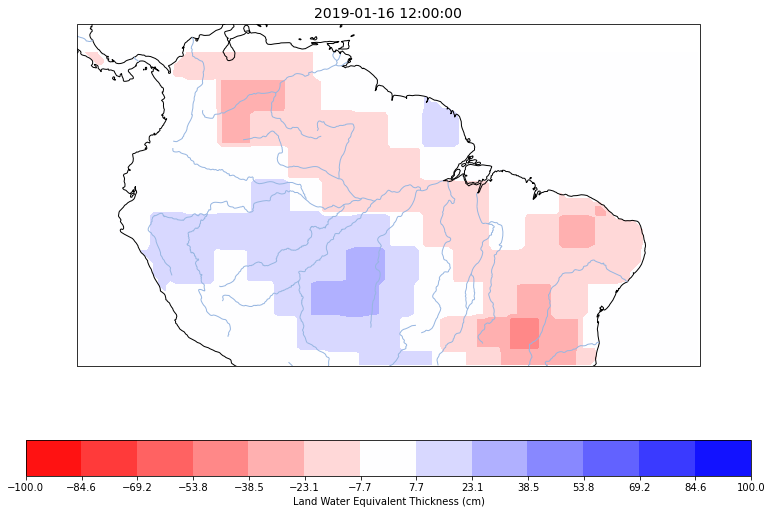

In [20]:
# Initialize a matplotlib plot object and add subplot:
fig = plt.figure(figsize=[13,9]) 
ax = fig.add_subplot(1, 1, 1)

# Configure axes to display projected data using PlateCarree crs:
pmap = plt.axes(projection=ccrs.PlateCarree())

# Get arrays of x and y to label the plot axes:
x,y = np.meshgrid(subset_GRACE.lon, subset_GRACE.lat)                        

# Set a few constants for plotting the GRACE-FO time series:
time_start  = 168
cmap_name   = "bwr_r"
cmap_levels = np.linspace(-100., 100., 14)
map_extent  = [-85, -30, -16, 11]

# Plot the first timestep: 
cont = setup_map(ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent)

fig.colorbar(cont, ticks=cmap_levels, orientation='horizontal', label='Land Water Equivalent Thickness (cm)')

#### Animate changes over time

Let's now explore how land water mass changes throughout the year 2019, by creating an animation of GRACE monthly land water equivalent (LWE) maps over the Amazon River.

Plot all the 2019 timesteps sequentially to create an animation of land water equivalent thickness for the Amazon Rainforest territories:

In [21]:
ani = animation.FuncAnimation(fig, animate_ts, frames=range(0,12), fargs=(
    ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent
), interval=500)

HTML(ani.to_html5_video())

Uncomment and run the next cell to save the animation to MP4:

In [22]:
#ani.save("earthdatacloud_animation_GRACEFO.mp4", writer=animation.FFMpegWriter())

## __Summary and Additional Resources__

The building blocks are now in place to do a longer time series analysis across GRACE and SMAP data, to better understand the relationship between river discharge and sea surface salinity for impact assessment. 

To conclude, we've searched programmatically for data archived in the PO.DAAC Earthdata Cloud over a region and time period of interest, requested the data from the Harmony API, read the data directly into `xarray` from the staged s3 location within AWS `us-west-2` without having to pull the data down into local storage, and performed subsetting and plotting in preparation for a time series analysis. 

____

## __Set up for in-region access__


__This notebook must be running within an AWS EC2 instance running in the `us-west-2` region.__

For the live AGU Workshop, our BinderHub instance already takes care of steps 1 and 2, but these instructions are provided so that you can set this up in your own AWS account outside of the workshop.

1. Follow tutorials 01 through 03 of the [NASA Earthdata Cloud Primer](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/cloud-primer) to set up an EC2 instance within us-west-2. Ensure you are also following step 3 in the ["Jupyter Notebooks on AWS EC2 in 12 (mostly easy) steps"](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6) article to set the correct security group settings needed to connect your local port to your EC2’s notebook port thru SSH.

2. Follow the remaining instructions in the Medium article above up until Step 11 (running Jupyter Lab). These instructions include installation of Anaconda3 (including Jupyter Lab) in your ec2 instance. Note the following updates and suggestions:
    * Step 5: Type the following command instead of what is suggested in the article: `ssh -i "tutorialexample.pem" ec2-user@ec2-54-144-47-199.compute-1.amazonaws.com -L 9999:localhost:8888`. This will eliminate the need to create a ssh config file in your home directory (Step 10).
    * As of December 2020, the most current Anaconda3 Linux distribution is: https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh
    * The Anaconda installation prompts are not the same as in the article. You will not be prompted to include Anaconda3 in your .bashrc PATH so you can skip to their step 9. Instead select "yes" to initialize Anaconda by running `conda init`. 

Before moving over to Jupyter Lab, set up your Earthdata Login authentication and Harmony access keys:

3. Setup your `~/.netrc` for Earthdata Login in your ec2 instance:

```
cd ~
touch .netrc
echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > .netrc
chmod 0600 .netrc
```

4. Run the following in your ec2 instance terminal window to generate short-term Harmony access keys:

`curl -Ln -bj https://harmony.earthdata.nasa.gov/cloud-access.sh`

5. Set your environment variables based on the keys provided in step 4:

`export AWS_ACCESS_KEY_ID='...
export AWS_SECRET_ACCESS_KEY='...'
export AWS_SESSION_TOKEN='...'
export AWS_DEFAULT_REGION='us-west-2'`

Note that these expire within 8 hours of the script generation.

6. Launch jupyter lab:

`jupyter lab --no-browser`

Copy the URL that begins with `http://localhost:8888` into a browser window. Replace `8888` with `9999`. 

You should now be up and running with JupyterLab in your EC2!
****